LightGBM

Convolutional Neural Networks (CNN) 

Long Short-Term Memory Networks (LSTM) 

Transformer-based Models


In [1]:
import pandas as pd


In [2]:
df = pd.read_csv('./solar_weather_processed.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Energy delta_Wh  196776 non-null  int64  
 1   GHI              196776 non-null  float64
 2   temp             196776 non-null  float64
 3   pressure         196776 non-null  float64
 4   humidity         196776 non-null  float64
 5   wind_speed       196776 non-null  float64
 6   rain_1h          196776 non-null  float64
 7   clouds_all       196776 non-null  float64
 8   Year             196776 non-null  int64  
 9   Month_num        196776 non-null  int64  
 10  DayOfYear        196776 non-null  int64  
 11  Minute           196776 non-null  int64  
 12  Hour             196776 non-null  int64  
 13  Season           196776 non-null  int64  
 14  Day              196776 non-null  int64  
 15  Week_cos         196776 non-null  float64
 16  Energy_lag_1     196776 non-null  floa

In [4]:
df['Energy delta_Wh'].describe()

count    196776.00000
mean        573.00310
std        1044.82681
min           0.00000
25%           0.00000
50%           0.00000
75%         577.00000
max        5020.00000
Name: Energy delta_Wh, dtype: float64

In [5]:
df.head()

,Energy delta_Wh,GHI,temp,pressure,humidity,wind_speed,rain_1h,clouds_all,Year,Month_num,DayOfYear,Minute,Hour,Season,Day,Week_cos,Energy_lag_1,Energy_lag_2
0,0,0.0,1.6,1021.0,100.0,4.9,0.0,100.0,2017,1,1,0,0,3,6,0.992981,0.0,0.0
1,0,0.0,1.6,1021.0,100.0,4.9,0.0,100.0,2017,1,1,15,0,3,6,0.992981,0.0,0.0
2,0,0.0,1.6,1021.0,100.0,4.9,0.0,100.0,2017,1,1,30,0,3,6,0.992981,0.0,0.0
3,0,0.0,1.6,1021.0,100.0,4.9,0.0,100.0,2017,1,1,45,0,3,6,0.992981,0.0,0.0
4,0,0.0,1.7,1020.0,100.0,5.2,0.0,100.0,2017,1,1,0,1,3,6,0.992981,0.0,0.0


# Seperate file for model buiding only


In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, record_evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [7]:
FEATURES = [col for col in df.columns if col != 'Energy delta_Wh']
X = df[FEATURES]
y = df['Energy delta_Wh']

In [8]:
# 7. Time-based train-test split (70-30)
train_size = int(len(df) * 0.7)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [9]:
# Initialize scalers
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))



In [10]:
# Helper function for RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Models

## lightGBM

#### basemodel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, record_evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize LightGBM model
model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=6,
    num_leaves=64,         
    bagging_fraction=0.8,  
    feature_fraction=0.8,  
    lambda_l1=0.1,         
    lambda_l2=0.1,         
    random_state=42,
)

evals_result = {}

# Train the model with scaled data
model.fit(
    X_train_scaled, y_train_scaled.ravel(),  # Ensure y is 1D
    eval_set=[(X_train_scaled, y_train_scaled.ravel()), (X_test_scaled, y_test_scaled.ravel())],
    eval_metric='rmse',
    callbacks=[record_evaluation(evals_result)]
)

# Predict with scaled data
y_pred_scaled = model.predict(X_test_scaled)

# Convert predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Calculate performance metrics using original values
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

# Plot the RMSE curve using scaled values directly
plt.figure(figsize=(10, 5))
plt.plot(evals_result["valid_0"]["rmse"], label="Training RMSE (Scaled)")
plt.plot(evals_result["valid_1"]["rmse"], label="Validation RMSE (Scaled)")
plt.xlabel("Iterations")
plt.ylabel("RMSE (Scaled)")
plt.title("LightGBM Model Training Progress")
plt.legend()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy generation')
plt.legend()
plt.show()

#### Hyperparameter for lightgbm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, record_evaluation
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize scalers
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale the features and target
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten()

# Define parameter grid
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'max_depth': [6, 8],
    'num_leaves': [64, 128],    
    'bagging_fraction': [0.8, 1.0],
    'feature_fraction': [0.8, 1.0],
    'lambda_l1': [0.0, 0.1],
    'lambda_l2': [0.0, 0.1]
}

# Use TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=2)

# Initialize LightGBM model
model = LGBMRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # Negative RMSE
    cv=tscv,
    verbose=1,
    n_jobs=2  # Limit parallelism
)

# Fit GridSearchCV on scaled training data
grid_search.fit(X_train_scaled, y_train_scaled)

# Best parameters and best RMSE (scaled)
print("Best Parameters (Grid Search):", grid_search.best_params_)
print("Best RMSE (CV) [Scaled]:", -grid_search.best_score_)

# Retrieve best model
best_model = grid_search.best_estimator_

# Display best model parameters
print("\nAll Best Model Hyperparameters:")
for param, value in best_model.get_params().items():
    print(f"{param}: {value}")

# Train the best model again to record evaluation results
evals_result = {}
best_model.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
    eval_metric='rmse',
    callbacks=[record_evaluation(evals_result)]
)

# Predict with scaled data
y_pred_scaled = best_model.predict(X_test_scaled)

# Convert predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluate using original scale
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nTest MAE:", mae)
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("R^2:", r2)



#### Best Model

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Prediction Time: 0.3176 seconds
MAE: 98.63859216833417
MSE: 60699.08012290522
RMSE: 246.3718330550496
R^2: 0.9434038341014805


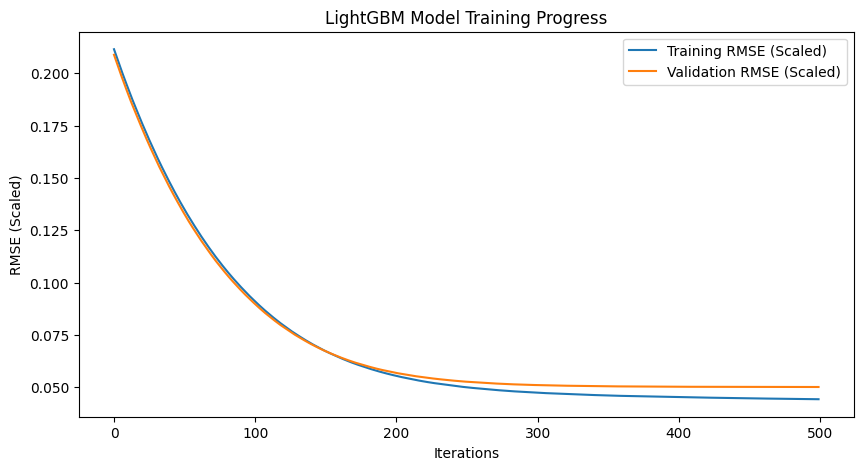

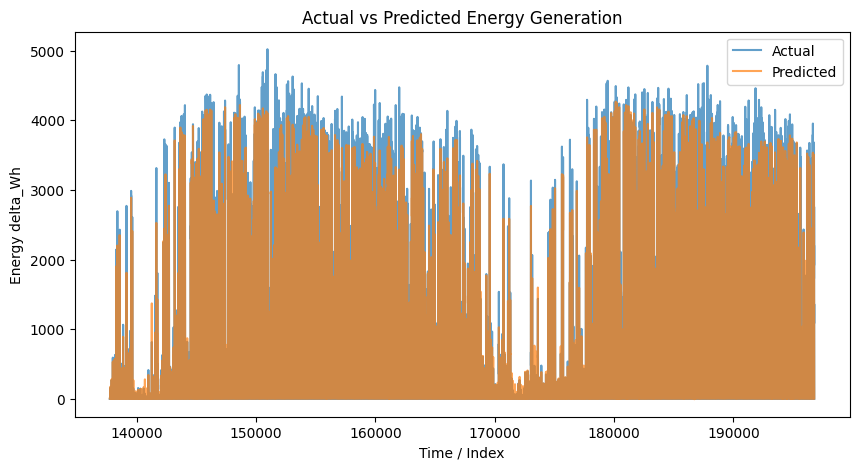

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, record_evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import time

# Initialize scalers
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale the features and target
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten()

# Best parameters from Grid Search
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=8,
    num_leaves=64,    
    bagging_fraction=0.8,
    feature_fraction=0.8,
    lambda_l1=0.1,
    lambda_l2=0.0,
    random_state=42,
)

# Dictionary to store training history
evals_result = {}

# Fit the model on the scaled training data
model.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
    eval_metric='rmse',
    callbacks=[record_evaluation(evals_result)]
)

# Save the trained model to a file
joblib.dump(model, 'lightgbm_model.pkl')
joblib.dump(scaler_x, 'scaler_x.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# Predict on the scaled test set
predict_start_time = time.time()
y_pred_scaled = model.predict(X_test_scaled)
predict_time = time.time() - predict_start_time

# Convert predictions back to original scale for final evaluation
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Evaluate the model using original scale
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Prediction Time: {predict_time:.4f} seconds")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

# Plot RMSE curve using scaled values
plt.figure(figsize=(10, 5))
plt.plot(evals_result["training"]["rmse"], label="Training RMSE (Scaled)")
plt.plot(evals_result["valid_1"]["rmse"], label="Validation RMSE (Scaled)")
plt.xlabel("Iterations")
plt.ylabel("RMSE (Scaled)")
plt.title("LightGBM Model Training Progress")
plt.legend()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy Generation')
plt.legend()
plt.show()


Metrics on Scaled Data:
Prediction Time: 0.3176 seconds
MAE (scaled): 0.0201
MSE (scaled): 0.0025
RMSE (scaled): 0.0501
R^2 (scaled): 0.9434


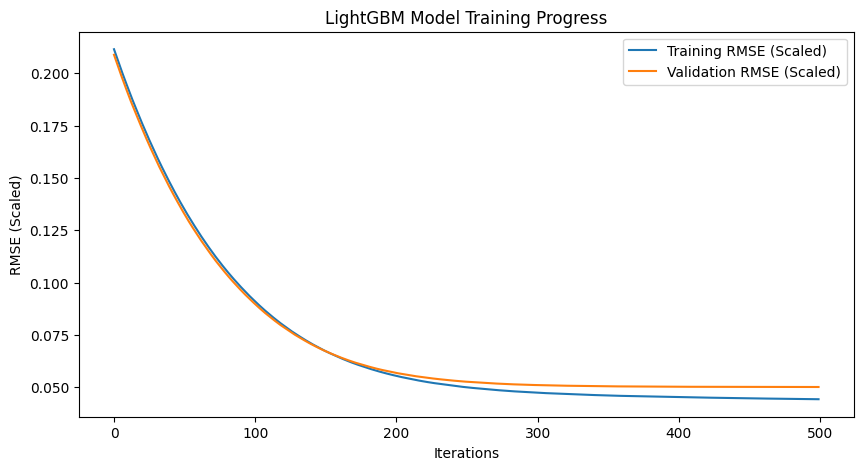

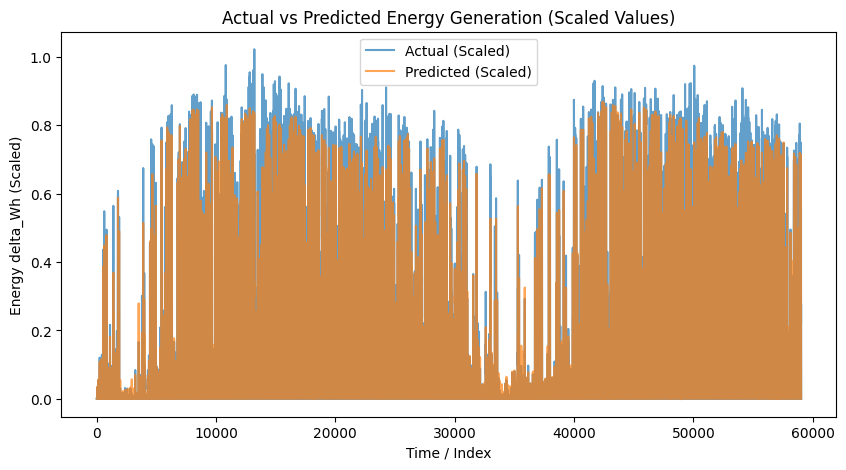

In [14]:
# Using scaled values directly without inverse transform
mae_scaled = mean_absolute_error(y_test_scaled, y_pred_scaled)
mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
rmse_scaled = np.sqrt(mse_scaled)
r2_scaled = r2_score(y_test_scaled, y_pred_scaled)

print("\nMetrics on Scaled Data:")
print(f"Prediction Time: {predict_time:.4f} seconds")
print(f"MAE (scaled): {mae_scaled:.4f}")
print(f"MSE (scaled): {mse_scaled:.4f}")
print(f"RMSE (scaled): {rmse_scaled:.4f}")
print(f"R^2 (scaled): {r2_scaled:.4f}")

# Plot RMSE curve using scaled values (same as before)
plt.figure(figsize=(10, 5))
plt.plot(evals_result["training"]["rmse"], label="Training RMSE (Scaled)")
plt.plot(evals_result["valid_1"]["rmse"], label="Validation RMSE (Scaled)")
plt.xlabel("Iterations")
plt.ylabel("RMSE (Scaled)")
plt.title("LightGBM Model Training Progress")
plt.legend()
plt.show()

# Plot actual vs predicted using scaled values
plt.figure(figsize=(10, 5))
plt.plot(y_test_scaled, label='Actual (Scaled)', alpha=0.7)
plt.plot(y_pred_scaled, label='Predicted (Scaled)', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh (Scaled)')
plt.title('Actual vs Predicted Energy Generation (Scaled Values)')
plt.legend()
plt.show()

## CNN

### Set up the CNN requirements

In [113]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import (Conv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Dense, SpatialDropout1D, BatchNormalization, Dropout)
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TerminateOnNaN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Sequence Creation with Striding
TIME_STEPS = 24  # 24 hours in 15-minute intervals

SEQ_STRIDE = 2


def create_sequences(X, y, time_steps, stride=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, stride):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS, SEQ_STRIDE)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS, SEQ_STRIDE)

### CNN Base Model 

In [ ]:
model = Sequential([
    # First Conv Block with Large Context
    Conv1D(32, 9, activation='relu', padding='causal',
           dilation_rate=1, kernel_regularizer=l2(1e-4),
           input_shape=(TIME_STEPS, X_train.shape[1])),
    MaxPooling1D(2),
    BatchNormalization(),
    SpatialDropout1D(0.2),
    
    # Second Conv Block with Medium Context
    Conv1D(64, 5, activation='relu', padding='causal',
           dilation_rate=3, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    SpatialDropout1D(0.3),
    
    # Third Conv Block with Local Context
    Conv1D(128, 3, activation='relu', padding='causal',
           dilation_rate=6, kernel_regularizer=l2(1e-4)),
    GlobalAveragePooling1D(),
    
    # Final Dense Layers
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(1)
])

optimizer = Adam(learning_rate=3e-4, clipnorm=0.5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(patience=20, monitor='val_mae', restore_best_weights=True),
    TerminateOnNaN()
]

#   Memory-Efficient Training
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=callbacks,
    verbose=1
)

#   Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

#   Evaluate
y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
mse = mean_squared_error(y_test_seq_unscaled, y_pred)
rmse = root_mean_squared_error(y_test_seq_unscaled, y_pred)
r2 = r2_score(y_test_seq_unscaled, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

#   Plot Training vs. Validation RMSE over epochs
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("CNN Model Training vs Validation RMSE")
plt.legend()
plt.show()

#   Plot Actual vs. Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy generation')
plt.legend()
plt.show()


### Hyperparameter for CNN

In [116]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, SpatialDropout1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

@tf.autograph.experimental.do_not_convert
def build_model(hp):
    # Hyperparameters for the first block
    filters_base = hp.Choice('filters_base', values=[32, 64])           
    kernel_size_first = hp.Choice('kernel_size_first', values=[9, 7])     
    # Other hyperparameters for optimizer and dense layer
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 3e-4])       
    l2_reg = hp.Choice('l2_reg', values=[1e-4, 1e-5])                  
    dropout_rate = hp.Choice('dropout_rate', values=[0.4, 0.3])     
    dense_units = hp.Choice('dense_units', values=[64, 128])  

    model = Sequential()
    
    # --------------------------
    # Block 1: Large Context
    # --------------------------
    model.add(Conv1D(filters=filters_base, 
                     kernel_size=kernel_size_first, 
                     activation='relu', 
                     padding='causal',
                     dilation_rate=1, 
                     kernel_regularizer=l2(l2_reg),
                     input_shape=(TIME_STEPS, X_train.shape[1])))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(0.2))
    
    # --------------------------
    # Block 2: Medium Context
    # --------------------------
    block2_filters = filters_base * 2
    block2_kernel = 5 if kernel_size_first == 9 else 3
    model.add(Conv1D(filters=block2_filters, 
                     kernel_size=block2_kernel, 
                     activation='relu', 
                     padding='causal',
                     dilation_rate=3, 
                     kernel_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(SpatialDropout1D(0.3))
    
    # --------------------------
    # Block 3: Local Context
    # --------------------------
    block3_filters = filters_base * 4
    block3_kernel = 3
    model.add(Conv1D(filters=block3_filters, 
                     kernel_size=block3_kernel, 
                     activation='relu', 
                     padding='causal',
                     dilation_rate=6, 
                     kernel_regularizer=l2(l2_reg)))
    model.add(GlobalAveragePooling1D())
    
    # --------------------------
    # Dense Layers
    # --------------------------
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate, clipnorm=0.5)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Create the tuner using GridSearch
tuner = kt.GridSearch(
    build_model,
    objective='val_mae',
    max_trials=64,              # 2^6 combinations (6 parameters with 2 choices each)
    executions_per_trial=1,     # Train 1 model per hyperparameter combination
    directory='hyperparameter_tuning',
    project_name='energy_prediction_cnn_grid',
    overwrite=True
)

# Define early stopping callback
stop_early = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Run grid search WITH early stopping
tuner.search(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[stop_early],    # Early stopping added back
    verbose=1
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Trial 64 Complete [00h 08m 14s]
val_mae: 0.032184798270463943

Best val_mae So Far: 0.03141651302576065
Total elapsed time: 07h 42m 03s
Best Hyperparameters:
filters_base: 64
kernel_size_first: 7
learning_rate: 0.0003
l2_reg: 1e-05
dropout_rate: 0.3
dense_units: 64


### Best Model for CNN

In [120]:
model = Sequential([
    # Block 1: Large Context (filters_base=64)
    Conv1D(64, 7, activation='relu', padding='causal',
           dilation_rate=1, kernel_regularizer=l2(1e-05),
           input_shape=(TIME_STEPS, X_train.shape[1])),
    MaxPooling1D(2),
    BatchNormalization(),
    SpatialDropout1D(0.2),

    # Block 2: Medium Context (double filters_base)
    Conv1D(128, 3, activation='relu', padding='causal',
           dilation_rate=3, kernel_regularizer=l2(1e-05)),
    BatchNormalization(),
    SpatialDropout1D(0.3),
    
    # Block 3: Local Context (quadruple filters_base)
    Conv1D(256, 3, activation='relu', padding='causal',
           dilation_rate=6, kernel_regularizer=l2(1e-05)),
    GlobalAveragePooling1D(),
    
    # Dense Layers (dense_units=64)
    Dense(64, activation='relu', kernel_regularizer=l2(1e-05)),
    Dropout(0.3),
    Dense(1)
])

# Compile with best learning rate
optimizer = Adam(learning_rate=0.0003, clipnorm=0.5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Callbacks (keeping your original configuration)
callbacks = [
    EarlyStopping(patience=20, monitor='val_mae', restore_best_weights=True),
    TerminateOnNaN()
]

# Training with best parameters
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=callbacks,
    verbose=1
)



Epoch 1/100
1076/1076 [==============================] - 34s 30ms/step - loss: 0.0185 - mae: 0.0694 - val_loss: 0.0104 - val_mae: 0.0441
Epoch 2/100
1076/1076 [==============================] - 34s 31ms/step - loss: 0.0113 - mae: 0.0478 - val_loss: 0.0110 - val_mae: 0.0451
Epoch 3/100
1076/1076 [==============================] - 34s 31ms/step - loss: 0.0098 - mae: 0.0445 - val_loss: 0.0086 - val_mae: 0.0401
Epoch 4/100
1076/1076 [==============================] - 34s 31ms/step - loss: 0.0091 - mae: 0.0428 - val_loss: 0.0094 - val_mae: 0.0417
Epoch 5/100
1076/1076 [==============================] - 34s 32ms/step - loss: 0.0085 - mae: 0.0416 - val_loss: 0.0076 - val_mae: 0.0379
Epoch 6/100
1076/1076 [==============================] - 35s 32ms/step - loss: 0.0079 - mae: 0.0406 - val_loss: 0.0072 - val_mae: 0.0358
Epoch 7/100
1076/1076 [==============================] - 35s 33ms/step - loss: 0.0074 - mae: 0.0396 - val_loss: 0.0078 - val_mae: 0.0380
Epoch 8/100
1076/1076 [==================

In [ ]:
# Evaluation and visualization
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

# Metrics
mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
mse = mean_squared_error(y_test_seq_unscaled, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_seq_unscaled, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# Training vs Validation RMSE plot
plt.figure(figsize=(12, 5))
plt.plot(np.sqrt(history.history['loss']), label='Training RMSE')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation RMSE')
plt.title('Model Performance: RMSE Comparison')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Actual vs Predicted plot
plt.figure(figsize=(12, 5))
plt.plot(y_test_seq_unscaled.flatten(), label='Actual', alpha=0.7)
plt.plot(y_pred.flatten(), label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Energy Generation')
plt.xlabel('Time Index')
plt.ylabel('Energy delta_Wh')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: Found array with dim 3. None expected <= 2.

## LSTM

### LSTM Environment setup

In [13]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from keras.layers import Add

# Temporal Attention Layer
class TemporalAttention(tf.keras.layers.Layer):
    def __init__(self, units=64, **kwargs):
        super().__init__(**kwargs)
        self.W1 = Dense(units, activation='tanh')
        self.W2 = Dense(1, activation='linear')
        self.layernorm = LayerNormalization()
    
    def call(self, inputs):
        score = self.W2(self.W1(inputs))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * inputs, axis=1)
        return self.layernorm(context_vector)

### Base Model LSTM

In [ ]:


# Pure LSTM Model with Fixed Learning Rate
def build_pure_lstm(time_steps, n_features):
    inputs = Input(shape=(time_steps, n_features))
    
    # First LSTM Block
    x = Bidirectional(LSTM(128, return_sequences=True,
                        dropout=0.3, recurrent_dropout=0.3,
                        kernel_regularizer=l2(1e-3)))(inputs)
    x = LayerNormalization()(x)
    
    # Second LSTM Block
    x = LSTM(64, return_sequences=True,
            dropout=0.2, recurrent_dropout=0.2,
            kernel_regularizer=l2(1e-3))(x)
    x = LayerNormalization()(x)
    
    # Temporal Attention
    x = TemporalAttention(units=64)(x)
    
    # Dimension-aligned Dense Network
    residual = Dense(64)(x)  # Residual projection
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Add()([x, residual])  # Residual connection
    
    outputs = Dense(1, kernel_regularizer=l2(1e-3))(x)
    
    model = Model(inputs, outputs)
    
    # Fixed learning rate optimizer
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae'])
    return model

# Training Setup
model = build_pure_lstm(TIME_STEPS, X_train.shape[1])

# Callbacks (only early stopping)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
1076/1076 [==============================] - 108s 95ms/step - loss: 0.3887 - mae: 0.1075 - val_loss: 0.2234 - val_mae: 0.0416
Epoch 2/100
1076/1076 [==============================] - 107s 99ms/step - loss: 0.1606 - mae: 0.0595 - val_loss: 0.1083 - val_mae: 0.0400
Epoch 3/100
1076/1076 [==============================] - 105s 98ms/step - loss: 0.0802 - mae: 0.0572 - val_loss: 0.0560 - val_mae: 0.0592
Epoch 4/100
1076/1076 [==============================] - 110s 103ms/step - loss: 0.0414 - mae: 0.0573 - val_loss: 0.0281 - val_mae: 0.0542
Epoch 5/100
1076/1076 [==============================] - 110s 102ms/step - loss: 0.0221 - mae: 0.0543 - val_loss: 0.0150 - val_mae: 0.0489
Epoch 6/100
1076/1076 [==============================] - 113s 105ms/step - loss: 0.0136 - mae: 0.0538 - val_loss: 0.0102 - val_mae: 0.0419
Epoch 7/100
1076/1076 [==============================] - 114s 106ms/step - loss: 0.0108 - mae: 0.0517 - val_loss: 0.0130 - val_mae: 0.0708
Epoch 8/100
1076/1076 [=======

923/923 [==============================] - 9s 9ms/step
MAE: 178.72783706354662
MSE: 114686.9477650265
RMSE: 338.6546142680275
R^2: 0.893185109783755


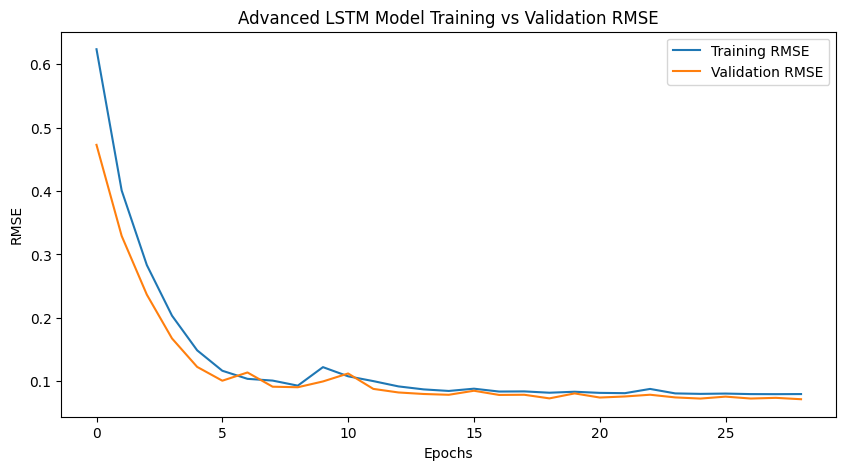

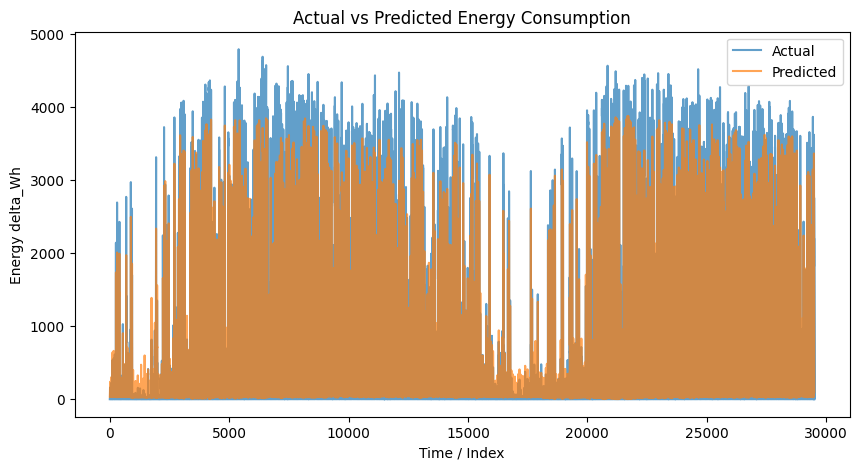

In [ ]:

# 1. Generate predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 2. Inverse-transform the test target
y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

# 3. Compute metrics
mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
mse = mean_squared_error(y_test_seq_unscaled, y_pred)
rmse = root_mean_squared_error(y_test_seq_unscaled, y_pred)
r2 = r2_score(y_test_seq_unscaled, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

# 4. Plot Training vs. Validation RMSE over epochs
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Advanced LSTM Model Training vs Validation RMSE")
plt.legend()
plt.show()

# 5. Plot Actual vs. Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy generation')
plt.legend()
plt.show()

### LSTM hyperparameter

In [ ]:
import tensorflow as tf
import keras_tuner as kt

def build_model(hp):
    inputs = tf.keras.Input(shape=(TIME_STEPS, X_train.shape[1]))
    
    # First LSTM layer with tunable units and dropout
    lstm_units1 = hp.Choice('lstm_units1', [128, 256])
    dropout1 = hp.Choice('dropout1', [0.2, 0.4])
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            lstm_units1,
            return_sequences=True,
            dropout=dropout1,
            recurrent_dropout=0.2,  # fixed value
            kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # fixed value
        )
    )(inputs)
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Second LSTM layer with tunable units; dropout fixed
    lstm_units2 = hp.Choice('lstm_units2', [64, 128])
    x = tf.keras.layers.LSTM(
        lstm_units2,
        return_sequences=True,
        dropout=0.2,  # fixed dropout2
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)  # fixed l2_reg
    )(x)
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Temporal Attention layer with tunable units
    attention_units = hp.Choice('attention_units', [64, 128])
    x = TemporalAttention(units=attention_units)(x)
    
    # Dense Network with fixed values
    dense_units = 64
    residual = tf.keras.layers.Dense(dense_units)(x)
    
    x = tf.keras.layers.Dense(128, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
    x = tf.keras.layers.Add()([x, residual])
    
    outputs = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    # Tunable learning rate
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

tuner = kt.GridSearch(
    build_model,
    objective='val_mae', # val_mae
    max_trials=32,  
    executions_per_trial=1,
    directory='tuning_results',
    project_name='lstm_attention_tuning'
)

# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True,
    min_delta=0.001
)

# Run hyperparameter search
tuner.search(
    X_train_seq, y_train_seq,
    epochs=20,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop],
    verbose=1
)

# Retrieve the best hyperparameters after search
best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
Best hyperparameters:
- LSTM 1 Units: {best_hps.get('lstm_units1')}
- Dropout 1: {best_hps.get('dropout1')}
- LSTM 2 Units: {best_hps.get('lstm_units2')}
- Attention Units: {best_hps.get('attention_units')}
- Learning Rate: {best_hps.get('learning_rate')}
""")


Trial 31 Complete [06h 23m 52s]
val_loss: 0.006255337502807379

Best val_loss So Far: 0.005423215916380286
Total elapsed time: 4d 08h 27m 47s

Best hyperparameters:
- LSTM 1 Units: 256
- Dropout 1: 0.2
- LSTM 2 Units: 64
- Attention Units: 64
- Learning Rate: 0.001




Total elapsed time: 4d 08h 27m 47s

Best hyperparameters:
- LSTM 1 Units: 256
- Dropout 1: 0.2
- LSTM 2 Units: 64
- Attention Units: 64
- Learning Rate: 0.001

### Best LSTM

In [ ]:
def build_pure_lstm(time_steps, n_features):
    inputs = Input(shape=(time_steps, n_features))
    
    # First LSTM Block with best hyperparameters
    x = Bidirectional(LSTM(256, return_sequences=True,
                           dropout=0.2, recurrent_dropout=0.2,
                           kernel_regularizer=l2(1e-3)))(inputs)
    x = LayerNormalization()(x)
    
    # Second LSTM Block remains as before
    x = LSTM(64, return_sequences=True,
             dropout=0.2, recurrent_dropout=0.2,
             kernel_regularizer=l2(1e-3))(x)S
    x = LayerNormalization()(x)
    
    # Temporal Attention layer with 64 units
    x = TemporalAttention(units=64)(x)
    
    # Dimension-aligned Dense Network with residual connection
    residual = Dense(64)(x)  # Residual projection
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Add()([x, residual])  # Residual connection
    
    outputs = Dense(1, kernel_regularizer=l2(1e-3))(x)
    
    model = Model(inputs, outputs)
    
    # Optimizer with fixed learning rate
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    return model

# Training Setup remains unchanged
model = build_pure_lstm(TIME_STEPS, X_train.shape[1])

# Callbacks (only early stopping)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.0001
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
1076/1076 [==============================] - 365s 334ms/step - loss: 0.4592 - mae: 0.1056 - val_loss: 0.2471 - val_mae: 0.0516
Epoch 2/100
1076/1076 [==============================] - 474s 440ms/step - loss: 0.1725 - mae: 0.0534 - val_loss: 0.1277 - val_mae: 0.1181
Epoch 3/100
1076/1076 [==============================] - 477s 443ms/step - loss: 0.0837 - mae: 0.0525 - val_loss: 0.0580 - val_mae: 0.0631
Epoch 4/100
1076/1076 [==============================] - 482s 448ms/step - loss: 0.0428 - mae: 0.0526 - val_loss: 0.0305 - val_mae: 0.0425
Epoch 5/100
1076/1076 [==============================] - 470s 437ms/step - loss: 0.0231 - mae: 0.0527 - val_loss: 0.0154 - val_mae: 0.0361
Epoch 6/100
1076/1076 [==============================] - 465s 432ms/step - loss: 0.0139 - mae: 0.0513 - val_loss: 0.0126 - val_mae: 0.0700
Epoch 7/100
1076/1076 [==============================] - 476s 442ms/step - loss: 0.0099 - mae: 0.0492 - val_loss: 0.0092 - val_mae: 0.0628
Epoch 8/100
1076/1076 [====

923/923 [==============================] - 39s 42ms/step
MAE: 167.61953028518175
MSE: 117764.4933305643
RMSE: 343.1683163267907
R^2: 0.8903188054821363


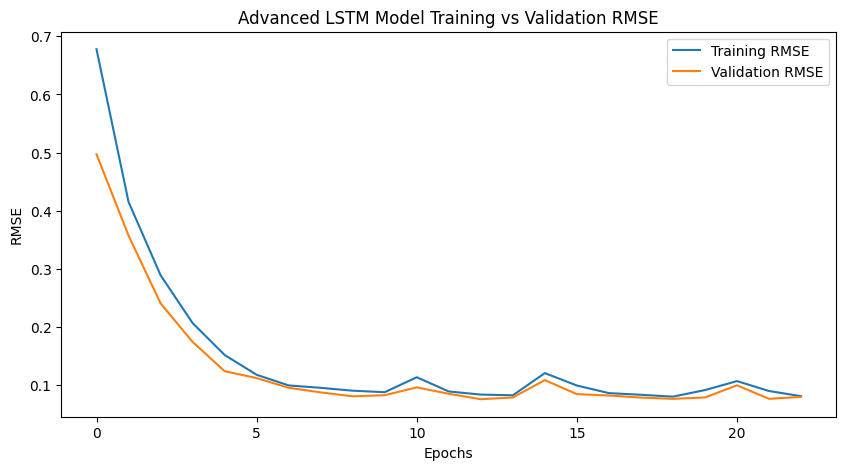

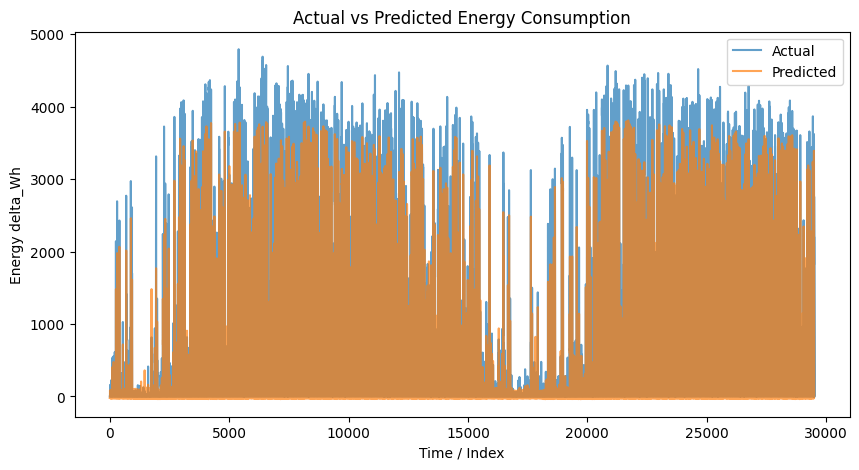

In [ ]:
# 1. Generate predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 2. Inverse-transform the test target
y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

# 3. Compute metrics
mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
mse = mean_squared_error(y_test_seq_unscaled, y_pred)
rmse = root_mean_squared_error(y_test_seq_unscaled, y_pred)
r2 = r2_score(y_test_seq_unscaled, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

# 4. Plot Training vs. Validation RMSE over epochs
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Advanced LSTM Model Training vs Validation RMSE")
plt.legend()
plt.show()

# 5. Plot Actual vs. Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy Generation')
plt.legend()
plt.show()

MAE: 175.3177967724385
MSE: 120655.65235174245
RMSE: 347.35522502438687
R^2: 0.887626094241119

## Transformer

#### Transformer Base Model 

In [117]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Lambda
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# ==============================================
# POSITIONAL ENCODING
# ==============================================
def positional_encoding(time_steps, d_model):
    position = np.arange(time_steps)[:, np.newaxis]  # shape (time_steps, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    pe = np.zeros((time_steps, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return tf.constant(pe[np.newaxis, ...], dtype=tf.float32)  # shape (1, time_steps, d_model)

# ==============================================
# TRANSFORMER ENCODER LAYER
# ==============================================
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(d_model)
        ])
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, inputs, training):
        # Pre-LN Architecture
        x_norm = self.layernorm1(inputs)
        attn_output = self.att(x_norm, x_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        
        x_norm = self.layernorm2(out1)
        ffn_output = self.ffn(x_norm)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output




Epoch 1/20
1076/1076 [==============================] - 389s 356ms/step - loss: 0.0464 - mae: 0.1097 - val_loss: 0.0057 - val_mae: 0.0358
Epoch 2/20
1076/1076 [==============================] - 1188s 1s/step - loss: 0.0095 - mae: 0.0516 - val_loss: 0.0061 - val_mae: 0.0385
Epoch 3/20
1076/1076 [==============================] - 387s 360ms/step - loss: 0.0082 - mae: 0.0466 - val_loss: 0.0088 - val_mae: 0.0473
Epoch 4/20
1076/1076 [==============================] - 381s 354ms/step - loss: 0.0075 - mae: 0.0450 - val_loss: 0.0045 - val_mae: 0.0347
Epoch 5/20
1076/1076 [==============================] - 384s 357ms/step - loss: 0.0072 - mae: 0.0441 - val_loss: 0.0056 - val_mae: 0.0372
Epoch 6/20
1076/1076 [==============================] - 379s 352ms/step - loss: 0.0070 - mae: 0.0437 - val_loss: 0.0046 - val_mae: 0.0321
Epoch 7/20
1076/1076 [==============================] - 368s 342ms/step - loss: 0.0066 - mae: 0.0425 - val_loss: 0.0045 - val_mae: 0.0331
Epoch 8/20
1076/1076 [==============

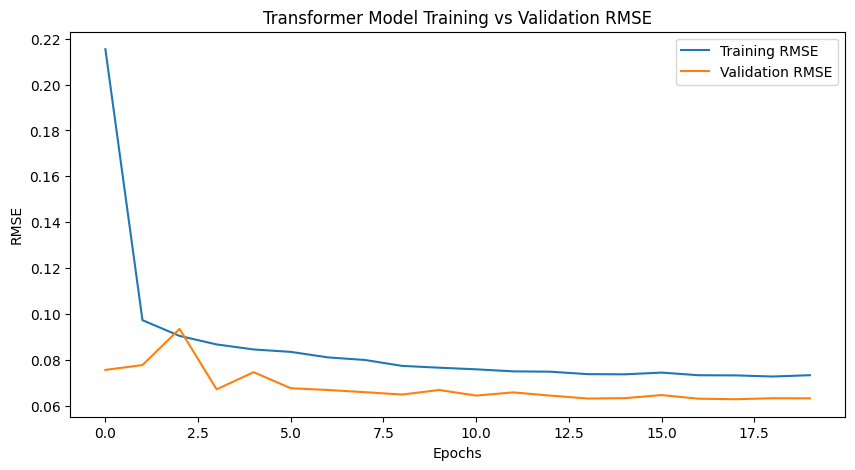

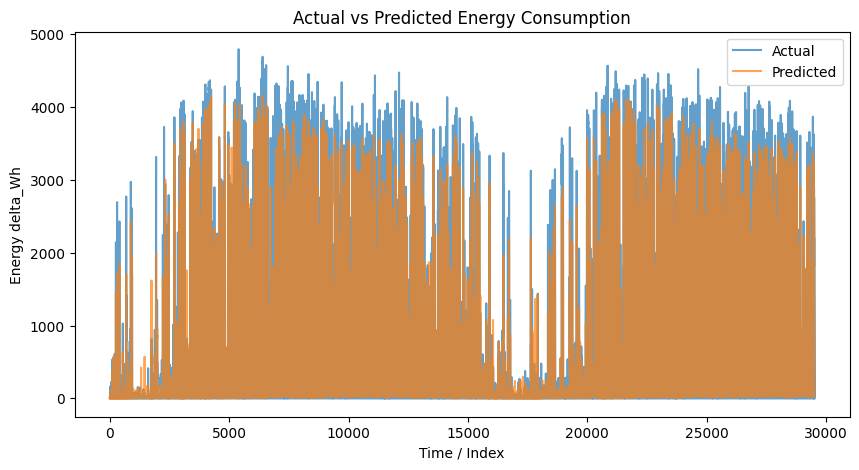

In [ ]:
d_model = 128
num_heads = 8
ff_dim = 256
dropout_rate = 0.2
num_encoder_layers = 4

# Positional encoding for 24 time steps
pe = positional_encoding(TIME_STEPS, d_model)

# ==============================================
# BUILD THE MODEL
# ==============================================
inputs = Input(shape=(TIME_STEPS, X_train.shape[1]))  # shape=(24, n_features)
x = Dense(d_model)(inputs)  # Project input to d_model dimension
x = x + pe  # Add positional encoding

# Stack multiple encoder layers
for _ in range(num_encoder_layers):
    x = TransformerEncoder(d_model, num_heads, ff_dim, dropout_rate)(x)

# Use final time step output for prediction
x = Lambda(lambda x: x[:, -1, :])(x)  # extract the last time step
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)

# ==============================================
# COMPILE & TRAIN
# ==============================================
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping],
    verbose=1
)

# ==============================================
# MAKE PREDICTIONS & EVALUATE
# ==============================================
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
mse = mean_squared_error(y_test_seq_unscaled, y_pred)
rmse = root_mean_squared_error(y_test_seq_unscaled, y_pred)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_seq_unscaled, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

# Plot training vs. validation RMSE
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Transformer Model Training vs Validation RMSE")
plt.legend()
plt.show()

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy generation')
plt.legend()
plt.show()


### Transformer Hyperparameter

In [ ]:
import itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Lambda
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==============================================
# GRID SEARCH SETUP
# ==============================================
param_grid = {
    'd_model': [32, 64, 128],       # Model dimension
    'num_heads': [4, 8],            # Attention heads
    'ff_dim': [64, 128, 256],       # Feed-forward dimension
    'dropout': [0.1, 0.2],          # Dropout rate
    'learning_rate': [1e-4, 3e-4]   # Learning rate
}

# Generate all possible combinations
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Total combinations: {len(hyperparameter_combinations)}")  # 3*2*3*2*2 = 72 combinations

# ==============================================
# TRAINING LOOP FOR GRID SEARCH
# ==============================================
best_val_mae = float('inf')
best_params = None
best_model = None

for params in hyperparameter_combinations:
    print(f"\nTraining with params: {params}")
    
    # Clear previous session to prevent memory leaks
    tf.keras.backend.clear_session()
    
    # Positional encoding
    pe = positional_encoding(TIME_STEPS, params['d_model'])
    
    # Build model
    inputs = Input(shape=(TIME_STEPS, X_train.shape[1]))
    x = Dense(params['d_model'])(inputs)
    x = x + pe
    
    for _ in range(4):  # Fixed num_layers=4 as before
        x = TransformerEncoder(
            params['d_model'],
            params['num_heads'],
            params['ff_dim'],
            params['dropout']
        )(x)
    
    x = Lambda(lambda x: x[:, -1, :])(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(params['dropout'])(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Train with early stopping
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=10,
        batch_size=64,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )
    
    # Track best model
    val_mae = np.min(history.history['val_mae'])
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_params = params
        best_model = model

# ==============================================
# EVALUATE BEST MODEL
# ==============================================
print("\nBest Parameters:", best_params)
y_pred_scaled = best_model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

mae = mean_absolute_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
r2 = r2_score(y_test_unscaled, y_pred)

print(f"\nFinal Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

In [32]:
import itertools
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Lambda
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==============================================
# GRID SEARCH SETUP (Impactful Parameters Only)
# ==============================================
param_grid = {
    'd_model': [32, 64, 128],       # Model dimension
    'num_heads': [4, 8],            # Attention heads
    'ff_dim': [64, 128, 256],       # Feed-forward dimension
    'dropout': [0.1, 0.2],          # Dropout rate
    'learning_rate': [1e-4, 3e-4]   # Learning rate
}

# Generate all possible combinations
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
print(f"Total combinations: {len(hyperparameter_combinations)}")  # 3*2*3*2*2 = 72 combinations

# ==============================================
# TRAINING LOOP FOR GRID SEARCH
# ==============================================
best_val_mae = float('inf')
best_params = None
best_model = None

for params in hyperparameter_combinations:
    print(f"\nTraining with params: {params}")
    
    # Clear previous session to prevent memory leaks
    tf.keras.backend.clear_session()
    
    # Positional encoding
    pe = positional_encoding(TIME_STEPS, params['d_model'])
    
    # Build model
    inputs = Input(shape=(TIME_STEPS, X_train.shape[1]))
    x = Dense(params['d_model'])(inputs)
    x = x + pe
    
    for _ in range(4):  # Fixed num_layers=4 as before
        x = TransformerEncoder(
            params['d_model'],
            params['num_heads'],
            params['ff_dim'],
            params['dropout']
        )(x)
    
    x = Lambda(lambda x: x[:, -1, :])(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(params['dropout'])(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    # Train with early stopping
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_test_seq, y_test_seq),
        epochs=10,
        batch_size=64,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )
    
    # Track best model
    val_mae = np.min(history.history['val_mae'])
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_params = params
        best_model = model

# ==============================================
# EVALUATE BEST MODEL
# ==============================================
print("\nBest Parameters:", best_params)
y_pred_scaled = best_model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))

mae = mean_absolute_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
r2 = r2_score(y_test_unscaled, y_pred)

print(f"\nFinal Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Total combinations: 72

Training with params: {'d_model': 32, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.1, 'learning_rate': 0.0001}

Training with params: {'d_model': 32, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.1, 'learning_rate': 0.0003}

Training with params: {'d_model': 32, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.2, 'learning_rate': 0.0001}

Training with params: {'d_model': 32, 'num_heads': 4, 'ff_dim': 64, 'dropout': 0.2, 'learning_rate': 0.0003}

Training with params: {'d_model': 32, 'num_heads': 4, 'ff_dim': 128, 'dropout': 0.1, 'learning_rate': 0.0001}

Training with params: {'d_model': 32, 'num_heads': 4, 'ff_dim': 128, 'dropout': 0.1, 'learning_rate': 0.0003}

Training with params: {'d_model': 32, 'num_heads': 4, 'ff_dim': 128, 'dropout': 0.2, 'learning_rate': 0.0001}

Training with params: {'d_model': 32, 'num_heads': 4, 'ff_dim': 128, 'dropout': 0.2, 'learning_rate': 0.0003}

Training with params: {'d_model': 32, 'num_heads': 4, 'ff_dim': 256, 'dropout': 0.1, 'learni

Best Parameters: {'d_model': 32, 'num_heads': 8, 'ff_dim': 256, 'dropout': 0.1, 'learning_rate': 0.0001}


### Transformer best model

Epoch 1/100
1076/1076 [==============================] - 223s 202ms/step - loss: 0.0222 - mae: 0.0890 - val_loss: 0.0064 - val_mae: 0.0392
Epoch 2/100
1076/1076 [==============================] - 312s 290ms/step - loss: 0.0067 - mae: 0.0445 - val_loss: 0.0055 - val_mae: 0.0371
Epoch 3/100
1076/1076 [==============================] - 316s 293ms/step - loss: 0.0060 - mae: 0.0398 - val_loss: 0.0060 - val_mae: 0.0384
Epoch 4/100
1076/1076 [==============================] - 333s 309ms/step - loss: 0.0055 - mae: 0.0375 - val_loss: 0.0048 - val_mae: 0.0347
Epoch 5/100
1076/1076 [==============================] - 327s 304ms/step - loss: 0.0052 - mae: 0.0363 - val_loss: 0.0044 - val_mae: 0.0320
Epoch 6/100
1076/1076 [==============================] - 325s 302ms/step - loss: 0.0051 - mae: 0.0356 - val_loss: 0.0042 - val_mae: 0.0297
Epoch 7/100
1076/1076 [==============================] - 328s 305ms/step - loss: 0.0049 - mae: 0.0351 - val_loss: 0.0048 - val_mae: 0.0342
Epoch 8/100
1076/1076 [====

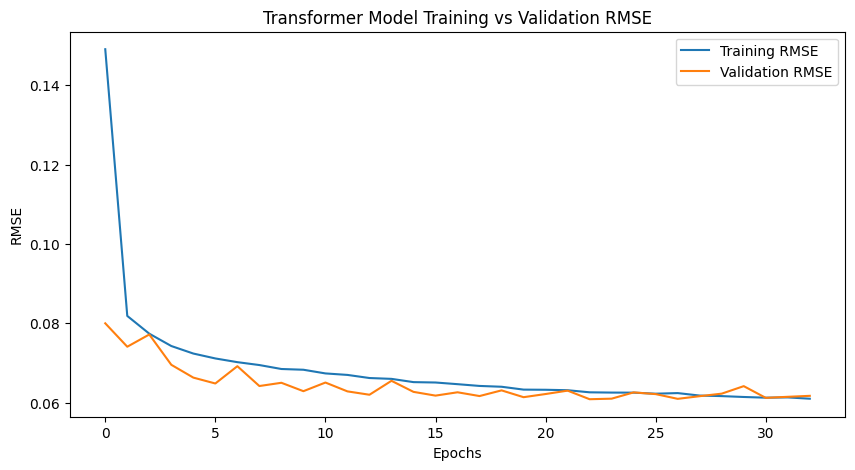

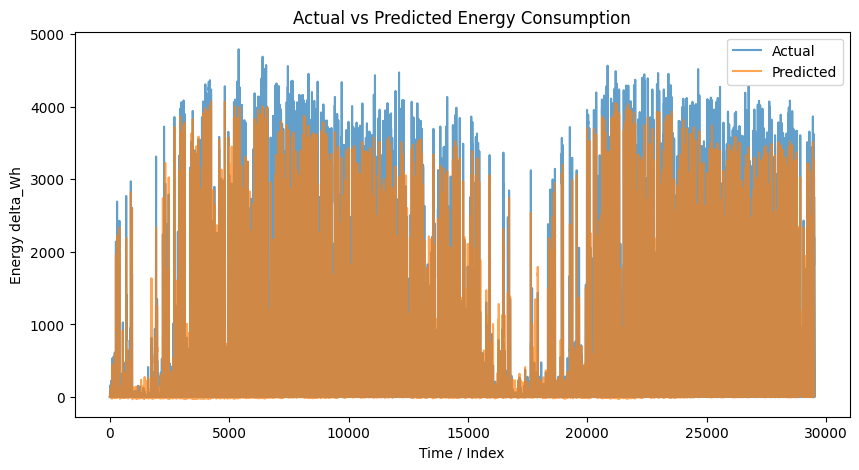

In [ ]:
d_model = 32
num_heads = 8
ff_dim = 256
dropout_rate = 0.1
num_encoder_layers = 4

# Positional encoding for 24 time steps
pe = positional_encoding(TIME_STEPS, d_model)

# ==============================================
# BUILD THE MODEL
# ==============================================
inputs = Input(shape=(TIME_STEPS, X_train.shape[1]))  # shape=(24, n_features)
x = Dense(d_model)(inputs)  # Project input to d_model dimension
x = x + pe  # Add positional encoding

# Stack multiple encoder layers
for _ in range(num_encoder_layers):
    x = TransformerEncoder(d_model, num_heads, ff_dim, dropout_rate)(x)

# Use final time step output for prediction
x = Lambda(lambda x: x[:, -1, :])(x)  # extract the last time step
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)

# ==============================================
# COMPILE & TRAIN
# ==============================================
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping],
    verbose=1
)

y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
mse = mean_squared_error(y_test_seq_unscaled, y_pred)
rmse = root_mean_squared_error(y_test_seq_unscaled, y_pred)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_seq_unscaled, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

# Plot training vs. validation RMSE
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Transformer Model Training vs Validation RMSE")
plt.legend()
plt.show()

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy Generation')
plt.legend()
plt.show()
